# End-2-end example using SQL databases

SuperDuperDB allows users to connect to a MongoDB database, or any one of a range of SQL databases, i.e. from this selection:

- MongoDB
- PostgreSQL
- SQLite
- DuckDB
- BigQuery
- ClickHouse
- DataFusion
- Druid
- Impala
- MSSQL
- MySQL
- Oracle
- pandas
- Polars
- PySpark
- Snowflake
- Trino

In this example we show case how to implement multimodal vector-search with DuckDB.
This is a simple extension of multimodal vector-search with MongoDB, which is 
just slightly easier to set-up (see [here](https://docs.superduperdb.com/docs/use_cases/items/multimodal_image_search_clip)).
Everything we do here applies equally to any of the above supported SQL databases, as well as to tabular data formats on disk, such as `pandas`.

## Prerequisites

Before working on this use-case, make sure that you've installed the software requirements:

In [ ]:
!pip install superduperdb[demo]

## Connect to datastore

The first step in any `superduperdb` workflow is to connect to your datastore.
In order to connect to a different datastore, add a different `URI`, e.g. `postgres://...`.

In [13]:
import os
from superduperdb import superduper

os.makedirs('.superduperdb', exist_ok=True)
db = superduper('duckdb://.superduperdb/test.ddb')

 2023-Nov-13 15:42:35.47| INFO     | Duncans-MacBook-Pro.local| superduperdb.backends.filesystem.artifacts:29   | Creating artifact store directory


## Load dataset

Now, Once connected, add some data to the datastore:

In [ ]:
!curl -O https://superduperdb-public.s3.eu-west-1.amazonaws.com/coco_sample.zip
!curl -O https://superduperdb-public.s3.eu-west-1.amazonaws.com/captions_tiny.json
!unzip coco_sample.zip
!mkdir -p data/coco
!mv images_small data/coco/images

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98.7M  100 98.7M    0     0  7455k      0  0:00:13  0:00:13 --:--:-- 8181k 309k      0  0:05:26 --:--:--  0:05:26  310k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  489k  100  489k    0     0   974k      0 --:--:-- --:--:-- --:--:--  981k
Archive:  coco_sample.zip
replace images_small/COCO_train2014_000000096202.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
import json
import pandas
import PIL.Image

with open(captions_tiny.json') as f:
    data = json.load(f)[:500]
    
data = pandas.DataFrame([
    {
        'image': r['image']['_content']['path'], 
         'captions': r['captions']
    } for r in data   
])
data['id'] = pandas.Series(data.index).apply(str)
images_df = data[['id', 'image']]

images_df['image'] = images_df['image'].apply(PIL.Image.open)
captions_df = data[['id', 'captions']].explode('captions')

FileNotFoundError: [Errno 2] No such file or directory: 'data/coco/captions_tiny.json'

## Define schema

This use-case requires a table with images, and a table with text. 
SuperDuperDB extends standard SQL functionality, by allowing developers to define
their own data-types via the `Encoder` abstraction.

In [3]:
from superduperdb.backends.ibis.query import Table
from superduperdb.backends.ibis.field_types import dtype
from superduperdb.ext.pillow import pil_image
from superduperdb import Schema

captions = Table(
    'captions', 
    primary_id='id',
    schema=Schema(
        'captions-schema',
        fields={'id': dtype(str), 'captions': dtype(str)},
    )
)

images = Table(
    'images', 
    primary_id='id',
    schema=Schema(
        'images-schema',
        fields={'id': dtype(str), 'image': pil_image},
    )
)

db.add(captions)
db.add(images)

[]

## Add data to the datastore

In [4]:
_ = db.execute(images.insert(images_df))
_ = db.execute(captions.insert(captions_df))

## Build SuperDuperDB `Model` instances

This use-case uses the `superduperdb.ext.torch` extension. 
Both models used, output `torch` tensors, which are encoded with `tensor`:

In [5]:
import clip
import torch
from superduperdb.ext.torch import TorchModel, tensor

# Load the CLIP model
model, preprocess = clip.load("RN50", device='cpu')

# Define a tensor type
t = tensor(torch.float, shape=(1024,))

# Create a TorchModel for text encoding
text_model = TorchModel(
    identifier='clip_text',
    object=model,
    preprocess=lambda x: clip.tokenize(x)[0],
    encoder=t,
    forward_method='encode_text',    
)

# Create a TorchModel for visual encoding
visual_model = TorchModel(
    identifier='clip_image',
    object=model.visual,    
    preprocess=preprocess,
    encoder=t,
)

## Create a Vector-Search Index

Let's define a mult-modal search index on the basis of the models imported above.
The `visual_model` is applied to the images, to make the `images` table searchable.

In [6]:
from superduperdb import VectorIndex, Listener

db.add(
    VectorIndex(
        'my-index',
        indexing_listener=Listener(
            model=visual_model,
            key='image',
            select=images,
        ),
        compatible_listener=Listener(
            model=text_model,
            key='captions',
            active=False,
            select=None,
        )
    )
)

 2023-Nov-13 12:13:46.39| INFO     | Duncans-MacBook-Pro.local| superduperdb.components.model:204  | Query <superduperdb.backends.ibis.query.IbisCompoundSelect[
    images.
] object at 0x15524e290> not found in metadata, adding...
 2023-Nov-13 12:13:46.50| INFO     | Duncans-MacBook-Pro.local| superduperdb.components.model:206  | Done
 2023-Nov-13 12:13:46.50| INFO     | Duncans-MacBook-Pro.local| superduperdb.components.model:207  | Adding model clip_image to db
 2023-Nov-13 12:13:46.64| INFO     | Duncans-MacBook-Pro.local| superduperdb.components.model:210  | Done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:51<00:00,  9.70it/s]


[]

## Search Images Using Text

Now we can demonstrate searching for images using text queries:

In [7]:
from superduperdb import Document

res = db.execute(
    images
        .like(Document({'captions': 'dog catches frisbee'}), vector_index='my-index', n=10)
        .limit(10)
)

 2023-Nov-13 12:14:43.59| INFO     | Duncans-MacBook-Pro.local| superduperdb.base.datalayer:100  | loading of vectors of vector-index: my-index


Loading vectors into vector-table...: 0it [00:00, ?it/s]/Users/dodo/SuperDuperDB/superduperdb/superduperdb/ext/torch/encoder.py:26: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return torch.from_numpy(array)
Loading vectors into vector-table...: 100it [00:00, 582.93it/s]

 2023-Nov-13 12:14:43.76| WARNING  | Duncans-MacBook-Pro.local| superduperdb.backends.ibis.query:211  | Disambiguation not yet supported of _fold_right: TODO!


Loading vectors into vector-table...: 500it [00:00, 2144.20it/s]


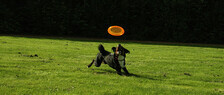

In [8]:
res[3]['image'].x